In [1]:

import numpy as np 
from scipy.constants.constants import C2K, K2C
import math
from scipy import optimize as opt # for optimization


In [17]:
#Create coefficient tables to solve for equations of state

PS_COEFF = np.zeros([10,10])
PS_COEFF[0][2]=0.24657688*math.pow(10,6)
PS_COEFF[0][3]=0.51359951*math.pow(10,2) 
PS_COEFF[1][2]=0.58638965*math.pow(10,0) 
PS_COEFF[1][3]=-0.28646939*math.pow(10,-2) 
PS_COEFF[1][4]=0.31375577*math.pow(10,-4) 
PS_COEFF[2][2]=-0.62783840*math.pow(10,1) 
PS_COEFF[2][3]=0.14791599*math.pow(10,-1) 
PS_COEFF[2][4]=0.35779579*math.pow(10,-3) 
PS_COEFF[2][5]=0.15432925*math.pow(10,-7) 
PS_COEFF[3][3]=-0.42719875*math.pow(10,0) 
PS_COEFF[3][4]=-0.16325155*math.pow(10,-4) 
PS_COEFF[4][2]=0.56654978*math.pow(10,4) 
PS_COEFF[4][3]=-0.16580167*math.pow(10,2) 
PS_COEFF[4][4]=0.76560762*math.pow(10,-1) 
PS_COEFF[5][3]=0.10917883*math.pow(10,0) 
PS_COEFF[6][0]=0.38878656*math.pow(10,13) 
PS_COEFF[6][1]=-0.13494878*math.pow(10,9) 
PS_COEFF[6][2]=0.30916564*math.pow(10,6)
PS_COEFF[6][3]=0.75591105*math.pow(10,1) 
PS_COEFF[7][2]=-0.65537898*math.pow(10,5) 
PS_COEFF[7][3]=0.18810675*math.pow(10,3) 
PS_COEFF[8][0]=-0.14182435*math.pow(10,14) 
PS_COEFF[8][1]=0.18165390*math.pow(10,9) 
PS_COEFF[8][2]=-0.19769068*math.pow(10,6)
PS_COEFF[8][3]=-0.23530318*math.pow(10,2)
PS_COEFF[9][2]=0.92093375*math.pow(10,5)
PS_COEFF[9][3]=0.12246777*math.pow(10,3)

CS = np.zeros([10]) 


#Constants
#CONSTANT_B = 2451 #(Holyoke and Kronenberg, 2010) #3631 (Stipp and Tullis, 2003)
#EXPONENT =  -1.26
#1.45E4 -1.47 Twiss 1977 #Get more from literature
#339 -0.58 Koch 1983 # from Gleason and Tullis, 1993 (GRL)
PIEZOMETERS = {
    'ST03': {'Constant_B': 3631, 'Exponent': -1.26},
    'HK10': {'Constant_B': 2451, 'Exponent': -1.26},
    'K83': {'Constant_B': 339, 'Exponent': -0.58},
    'T77': {'Constant_B': 1.45E4, 'Exponent': -1.47}
}



FLOW_LAWS = {
    "KT84": {"A": 2.2E-6, "n": 2.7, "Q": 1.2E5},
    'GT95wm': {"A": 1.8E-8, "n": 4, "Q": 1.37E5},
    'J84': {"A": 2.88E-3, "n": 1.8, "Q": 1.51E5},
    'K89': {"A": 1.1E-6, "n": 2.7, "Q": 1.34E5},
    'HC82': {"A": 1.99E-2, "n": 1.8, "Q": 1.67E5},
    'LP92g': {"A": 6.6E-8, "n": 3.1, "Q": 1.35E5},
    'LP92a': {"A": 3.98E-10, "n": 4, "Q": 1.35E5},
    "H01":  {"A": 6.3E-12, "n": 4, "Q": 1.35E5}, 
    "RB04": {"A": 1.2E-5, "n": 2.97, "Q": 2.42E5}
    }




def calculate_coefficient_table(temperature):
    for i in range(0, len(PS_COEFF)):
        CS[i]=PS_COEFF[i][0]*math.pow(temperature,-4)+PS_COEFF[i][1]*math.pow(temperature,-2)\
        +PS_COEFF[i][2]*math.pow(temperature,-1)\
        +PS_COEFF[i][3]+PS_COEFF[i][4]*temperature+PS_COEFF[i][5]*math.pow(temperature,2)



#CALCULATE EQUATIONS OF STATE AND FUGACITY
#Solve Equation of state, Eq 2 of Pitzer and Sterner (1994)
#Returns pressure in Pa
def eos(T, V):
    den = 1/V
    R = 8314472
    var_num = CS[2]+2*CS[3]*den+3*CS[4]*math.pow(den,2)+4*CS[5]*math.pow(den,3)
    var_denom = math.pow((CS[1]+CS[2]*den+CS[3]*math.pow(den,2)+CS[4]*math.pow(den,3)+CS[5]*math.pow(den,4)),2)
    pressure=den+CS[0]*math.pow(den,2)-math.pow(den,2)*(var_num/var_denom)
    pressure= pressure + (CS[6]*math.pow(den,2)*math.exp(-CS[7]*den)+CS[8]*math.pow(den,2)*math.exp(-CS[9]*den))
    pressure = pressure*(R*T) #pressure in Pa
    return pressure

#Solve for fugacity, Eq 1 of Pitzer and Sterner (1994)
#Returns fugacity in MPa
def PSfug(P,T,V):
    den=1/V;
    R=8314472;
    quotient = CS[0]*den+(1/(CS[1]+CS[2]*den+CS[3]*math.pow(den,2)+CS[4]*math.pow(den,3)+CS[5]*math.pow(den,4))-1/CS[1])
    quotient-= CS[6]/CS[7]*(math.exp(-CS[7]*den)-1)
    quotient-= CS[8]/CS[9]*(math.exp(-CS[9]*den)-1)
    lnf=(math.log(den)+ quotient+P/(den*R*T))+math.log(R*T)-1
    return math.exp(lnf)/1e6 # fugacity in MPa

#Optimizing equation to solve for volume
def fugacity_optimizer(temperature,pressure):

    def fun(v):
        return eos(temperature, v)- pressure
    volume = opt.brentq(fun, 5, 30) #Volume in cc/mo

    #Calculate fugacity 
    fugacity = PSfug(pressure, temperature, volume)
    
    return fugacity



    ##CALCULATE FUGACITY
#Takes imputs of pressure and temperature converts them from MPa and C to Pa and K 

class FlowStressCalculator():

    def __init__(self, temperature_values, pressure_values):
        self.temperature = C2K(np.array(temperature_values))
        self.pressure = np.array(pressure_values)*1.0E6
        self.grain_size = []
        self.fugacity = []
        self.differential_stress = []
        self.strain_rate = []
        self.slip_rate= []  

        
    def calculate_fugacity(self):
        
        for t in self.temperature:
            for p in self.pressure:
                calculate_coefficient_table(t)
                fug = fugacity_optimizer(t,p)
                self.fugacity.append(fug)
        return self.fugacity


    def calculate_differential_stress(self, grain_size, paleopiezometer='HK10'):
        
        for grain in grain_size:
            part = math.exp((math.log(grain)-math.log(PIEZOMETERS[paleopiezometer]['Constant_B']))/PIEZOMETERS[paleopiezometer]['Exponent'])
            self.differential_stress.append(part)
        return self.differential_stress


    def calculate_strain_rate(self, flow_law='H01'):

        for stress in self.differential_stress:
            for t, f in zip(self.temperature, self.fugacity):
                sr_i = (FLOW_LAWS[flow_law]['A']*np.power(stress, FLOW_LAWS[flow_law]['n'])*np.power(f,1)*np.exp(-FLOW_LAWS[flow_law]['Q']/(8.3144598*t)))
                self.strain_rate.append(sr_i)

        return self.strain_rate
        

    def calculate_slip_rate(self, width): #width in m, output of mm/yr
        
        for w in width: 
            for strain in self.strain_rate:
                vel = w*1000*31536000*strain
                self.slip_rate.append(vel)
            
        return self.slip_rate

In [37]:

temp = range(300, 600)
pressure = [400]
grain_size = range(3, 35, 3)#range(5,10)#[10,12,13,16,27,29]##[5,6,7,8,9,10,11,12,13,14,15,30] #List of grainsizes 
width = [30]


In [38]:
f = FlowStressCalculator(temp,pressure)
fugacity = f.calculate_fugacity()

differential_stress = f.calculate_differential_stress(grain_size)#, paleopiezometer = 'T77')

strain_rate= f.calculate_strain_rate()

slip_rate = f.calculate_slip_rate(width)


#convert K back to C for plotting
temperature_C = K2C(f.temperature)


In [26]:
slip77 = slip_rate
strain77 = strain_rate

In [24]:
temperature = f.temperature

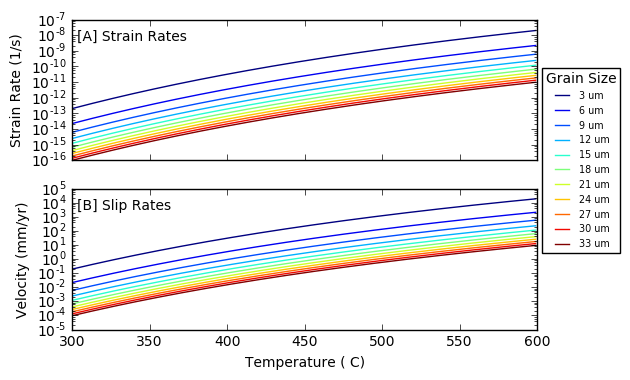

In [46]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages



def plot_strain_slip_rates(temperature, strain_rate, slip_rate):
    
    temperature_C = K2C(temperature)
    #Group the data for plotting
    sr_grouped = [strain_rate[x:x+len(temperature)] for x in xrange(0, len(strain_rate), len(temperature))]
    sl_grouped = [slip_rate[x:x+len(temperature)] for x in xrange(0, len(slip_rate), len(temperature))]
    
    
    fig = plt.figure()
    sub1 = fig.add_subplot(2,1,1)
    sub1.set_yscale('log')
    sub1.text(0.01, 0.85, '[A] Strain Rates', transform=sub1.transAxes, fontsize=10)
    sub1.set_ylabel('Strain Rate (1/s)')
    sub1.legend(loc='upper left')

    
    sub2 = fig.add_subplot(2,1,2, sharex=sub1)
    sub2.set_yscale('log')
    sub2.text(0.01, 0.85, '[B] Slip Rates', transform=sub2.transAxes, fontsize=10)
    sub2.set_xlabel('Temperature ( C)')
    sub2.set_ylabel("Velocity (mm/yr)")
    

    plt.setp(sub1.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace = 0.2)

    colors=iter(cm.jet(np.linspace(0,1,len(grain_size))))
    colors2=iter(cm.jet(np.linspace(0,1,len(grain_size))))
    for i, grain in enumerate(grain_size):
        sub1.plot(temperature_C, sr_grouped[i], color=next(colors), label=(str(grain) + ' um'))
        sub1.legend(loc='center left', bbox_to_anchor=(1, 0), title="Grain Size", fontsize = 'x-small')
        sub2.plot(temperature_C, sl_grouped[i], color=next(colors2))

    plt.show()
    return fig
fig = plot_strain_slip_rates(f.temperature, strain_rate, slip_rate)
fig.set_size_inches(9,6)
export_pdf(fig, 'strain_slip_rates')

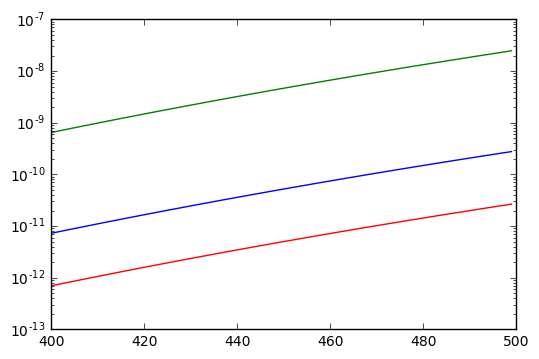

In [120]:
# plot_strain_slip_rates(f.temperature, strain77, slip77)
temp = range(400,500)
grain_size =[10]


f = FlowStressCalculator(temp,pressure)
fugacity = f.calculate_fugacity()
differential_stress = f.calculate_differential_stress(grain_size)#, paleopiezometer = 'T77')
strain_rate= f.calculate_strain_rate()
slip_rate = f.calculate_slip_rate(width)


f77 = FlowStressCalculator(temp,pressure)
f77.calculate_fugacity()
f77.calculate_differential_stress(grain_size, paleopiezometer = 'T77')
sr77 = f77.calculate_strain_rate()

f83 = FlowStressCalculator(temp,pressure)
f83.calculate_fugacity()
f83.calculate_differential_stress(grain_size, paleopiezometer = 'K83')
sr83 = f83.calculate_strain_rate()



# def piezometer_compare(temperature, pressure, grain_size, paleopiezometer):
#     f = FlowStressCalculator(temperature, pressure)
#     f.calculate_fugacity()
#     f.calculate_differential_stress(grain_size, paleopiezometer)
    






def chunker(temperature, data):
    chunk = [data[x:x+len(temperature)] for x in xrange(0, len(data), len(temperature))]
    
    return chunk
    
sr10_c = chunker(f.temperature, strain_rate)
sr77_c = chunker(f.temperature, sr77)
sr83_c = chunker(f.temperature, sr83)


temperature_list = K2C(f.temperature.tolist())
fig = plt.figure()
plt.plot(temperature_list, sr10_c[0], 'r')
plt.yscale('log')
plt.plot(temperature_list, sr77_c[0], 'b')
plt.plot(temperature_list, sr83_c[0], 'g')

plt.show()

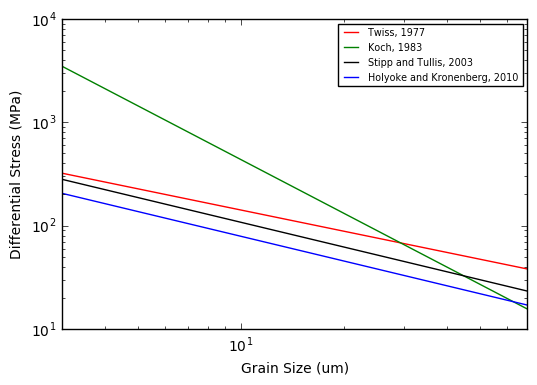

In [31]:
temp = [450]
grain_size =range(3,70)

f77 = FlowStressCalculator(temp,pressure)
f77.calculate_fugacity()
ds77 = f77.calculate_differential_stress(grain_size, paleopiezometer = 'T77')

f10 = FlowStressCalculator(temp,pressure)
f10.calculate_fugacity()
ds10 = f10.calculate_differential_stress(grain_size, paleopiezometer = 'HK10')

f83 = FlowStressCalculator(temp,pressure)
f83.calculate_fugacity()
ds83 = f83.calculate_differential_stress(grain_size, paleopiezometer = 'K83')

f03 = FlowStressCalculator(temp,pressure)
f03.calculate_fugacity()
ds03 = f03.calculate_differential_stress(grain_size, paleopiezometer = 'ST03')

#temperature_list = K2C(f77.temperature).tolist()


fig = plt.figure()
plt.yscale('log')
plt.xscale('log')
plt.plot(grain_size, ds77, 'r', label='Twiss, 1977')
plt.plot(grain_size, ds83, 'g', label='Koch, 1983')
plt.plot(grain_size, ds03, 'k', label='Stipp and Tullis, 2003')
plt.plot(grain_size, ds10, 'b', label='Holyoke and Kronenberg, 2010')
plt.xlim([min(grain_size),max(grain_size)])
plt.legend(loc='upper right', fontsize = 'x-small')
plt.xlabel('Grain Size (um)')
plt.ylabel('Differential Stress (MPa)')

plt.show()

In [34]:
#Export PDF file
def export_pdf(fig, title='title'):
    pdf = PdfPages(title+'.pdf')
    pdf.savefig(fig)#, bbox_inches='tight')
    pdf.close()

In [35]:
export_pdf(fig, 'Paleopiezometers')

In [89]:


# #Calculate strain and slip rates at these grain sizes and shear zone width
# accumulated_strain_rates = []
# accumulated_slip_rates = []
# for i, grain in enumerate(grain_size):
#     s = calculate_differential_stress([grain])
#     sr = calculate_strain_rate(s, fugacity_calculations, flow_law='H01')
#     accumulated_strain_rates.append(sr)
#     v = calculate_slip_rate(sr, width)
#     accumulated_slip_rates.append(v)


    
    
#Creat plot and labels



#add temperature range to plot
x=[450,450]
y=[1.0E-8,1.0E-16]
sub1.plot(x,y,linestyle='-', color='k', linewidth=112, alpha=0.3)   
    




#Add typical slip rates around the world
y=[22, 22]
x=[300, 600]
sub2.plot(x, y, linestyle='-', color='k', linewidth=14, alpha=0.5)
#add temperature range to plot
x=[450,450]
y=[1.0E4,1.0E-4]
sub2.plot(x,y,linestyle='-', color='k', linewidth=112, alpha=0.3)

colors=iter(cm.jet(np.linspace(0,1,len(grain_size))))
for i, grain in enumerate(grain_size):
    sub2.plot(temperature_C, slip_rate_chunks[i], color=next(colors))
    sub2.set_yscale('log')
    
colors=iter(cm.jet(np.linspace(0,1,len(grain_size))))
for i, grain in enumerate(grain_size):
    sub1.plot(temperature_C, strain_rate_chunks[i], color=next(colors))
    sub1.set_yscale('log')
    


#Export PDF file
pdf = PdfPages('Strain_Slip_Rates.pdf')
pdf.savefig(fig)
pdf.close()


plt.show()




NameError: name 'sub1' is not defined

In [210]:
## Working with the simulators

temp = [450]
pressure = [400]
grain_size = [7]#range(3,21)#[5,6,7,8,9,10,11,12,13,14,15,30] #List of grainsizes 
width = [30]

#Calculate fugacity
f = FugacityCalculator(temp,pressure)
fugacity_calculations = f.calculate_fugacity()


#Calculate strain and slip rates at these grain sizes and shear zone width
accumulated_strain_rates = []
accumulated_slip_rates = []
for i, grain in enumerate(grain_size):
    s = calculate_differential_stress([grain])
    sr = calculate_strain_rate(s, fugacity_calculations, flow_law='H01')
    accumulated_strain_rates.append(sr)
    v = calculate_slip_rate(sr, width)
    accumulated_slip_rates.append(v)
    
print(v, sr)

x = simulate_slip_and_strain(35, 0.5, 5.557674678407064e-13)
x

([14.73072143854492], [1.557027041956803e-11])


([0.6134339003038581], [0.0])

In [284]:
## Simulators, this is for future work/ work in progress.
from mpmath import mp

#define conversion from mm/yr to mm/sec
conv = float(mp.fdiv(1, 31536000))

#grain_size = [5, 6, 7, 8, 9, 10]
def simulate_width(slip_rate, strain_rate):
    #v=w*e
    width = []
    for slip in slip_rate:
        for strain in strain_rate:
            w = (slip/(strain*31536000))/1000
            if w < 30 or w == 30:
                
                width.append(w)
            else:
                width.append(str("ERROR: Too wide"))
            
    return width




def simulate_slip_and_strain(width, slip_rate=14.7, strain_rate=1.557027041956803e-11):
    slip_rate = []
    strain = []
    width = [width]
        
    print(len(slip_rate))
    
    if len(slip_rate) == 1: #constant stress condition
        for w in width:
            st = slip_rate*conv/(w*1000)
        return st
    
    elif len(strain_rate) == 1: #constant strain rate condition
        for w in width:
            sl = strain_rate*31536000*w*1000
        return sl
    
    


In [417]:
width=30
strain_rate=1.5E-11

def simulator(width, strain_rate):
    v=15.
    
    w=(v/1000)/(strain_rate*31536000)
    
    e=(v/31536000)/(width*1000)

    return w, e, v

simulator(width, strain_rate)





(31.709791983764585, 1.5854895991882293e-11, 15.0)

In [49]:
#Measuring grain sizes
#PS027 16pm7 n=19
#PS029 13pm7 n=70
#PS030 coarse section: 24 pm 13 n=46, fine: 10pm5 n=43 
#PS031 16pm13 n=50
#PS032 10pm7 n=66
#PS189 34pm17 n=31, 23pm13 n=30,  combined: 29pm16 n=61
#PS201 13pm5 n=33
#PS202 12pm6 n=35
#PS206 27pm15 n=51

#10,12,13,16,27,29

#Sample PS030
d = [2.9, 2.6, 0.8, 2.9, 1.8, 2.4, 1.2, 1.4, 1.4, 0.8, 1.5, 4.7, 1.5, 1.0, 0.6,
     0.7, 0.4, 1.9, 3, 0.4, 0.3, 0.7, 0.5, 0.9, 0.8]
#note: resoultion is ~0.25mm or 2 microns
conversion = 10689.3
#micron = d*conversion

def calc_grain_size(d): 
    micron = []
    for i in range(0, len(d)):
        m = d[i]*(300/35.631)
        mr = round(m,2)
        micron.append(mr)
    return micron

# print(micron)
# print(len(micron), max(micron), min(micron))
# print(round(np.mean(micron)))
# print(round(np.std(micron)))


In [95]:
d = [8, 13, 10, 12] #11pm6
d = [13, 16, 16, 24, 29] #20pm12

print(np.mean(d))


19.6


In [94]:
var = [25, 49, 49, 36]
sum(var)
125/4
math.sqrt(31)

5.5677643628300215

In [99]:
var = [49, 169, 169, 25, 256]
a = sum(var)
b = a/len(var)
math.sqrt(b)

11.532562594670797